# Task Overview

Your task will be to implement a *RevNet* (Reversible Residual Network) – a variant of ResNet where each layer's activations can be reconstructed exactly from the next layer. Therefore, the activations for most layers need not be stored in memory to perform backpropagation.

You can find more information about RevNet here: [link](https://arxiv.org/pdf/1707.04585.pdf)

You should use an MLP architecture trained on the MNIST dataset. You should implement the network in numpy.

Tasks:
1. (10pt) Fill missing code below
  - 1pt implement the `__init__` method
  - 2pt implement the feedforward method
  - 2pt implement the mini-batch update
  - 5pt implement the backpropagation (note: if you implement backpropagation example-by-example instead of whole minibatch at once, you will get maximum of 2pt for this part)
2. Train the models (find proper hyperparameters). Visualize training of your best model (plot training and test loss/accuracy in time). Your model should reach at least 96% accuracy. Use clear ml for logging your scores. Make a comparison of memory usage for your network and the network you implemented in lab 3.
  - 1pt for accuracy above 96%
  - 1pt for visualizations (we recommend downloading plots from clear ml)
  - 2pt if [clear ml](https://clear.ml/docs/latest/docs/) used properly
  - 1pt for comparing memory usage.



## Potential questions, clarifications
- Q: Can I save the output of the last layer before classification (a -> 10)?
  - Yes.
- Q: MNIST has only one channel, how do I split that into two groups for implementing ReVNet blocks?
  - You can split activations into two groups, so if a layer has size $a$ you can split it into $2 \cdot a/2$.
- Q: Can I modify code of ReVNet outside #Your code goes here # to include logging?
  - Yes, in ReVNet.SGD

# Imports

In [502]:
!pip install clearml --quiet
!pip install memory-profiler --quiet

In [503]:
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from clearml import Task
from memory_profiler import profile
import plotly.express as px

In [504]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


# Dataset loading


In [505]:
!wget -O mnist.npz https://s3.amazonaws.com/img-datasets/mnist.npz

--2023-11-27 04:39:04--  https://s3.amazonaws.com/img-datasets/mnist.npz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.134.232, 54.231.133.80, 52.217.173.48, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.134.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11490434 (11M) [application/octet-stream]
Saving to: ‘mnist.npz’

mnist.npz           100%[===================>]  10.96M  50.3MB/s    in 0.2s    

2023-11-27 04:39:05 (50.3 MB/s) - ‘mnist.npz’ saved [11490434/11490434]



In [506]:
def load_mnist(path='mnist.npz'):
    with np.load(path) as f:
        x_train, _y_train = f['x_train'], f['y_train']
        x_test, _y_test = f['x_test'], f['y_test']

    x_train = x_train.reshape(-1, 28 * 28) / 255.
    x_test = x_test.reshape(-1, 28 * 28) / 255.

    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1

    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist()

# Set up clear ml

In [507]:
### Your code goes here ###
web_server = 'https://app.clear.ml'
api_server = 'https://api.clear.ml'
files_server = 'https://files.clear.ml'
access_key = '6J57OW75HUGR233GVN8F'
secret_key = 'nRAN9jk7iTe6OXXu01nYo0hodsN5mV1UzhdIeEfYPLQ8XKNg70'
Task.set_credentials(web_host=web_server,
                     api_host=api_server,
                     files_host=files_server,
                     key=access_key,
                     secret=secret_key)

task = Task.init(project_name="hw1", task_name="revnet_trackings")

config = {
    'n_epochs': 25,
    'lr': 0.3,
    'mini_batch_size': 100,
    'network_size': [784, 32, 32, 10],
}
###########################

# Network definition (as in laboratory 3)


In [508]:
network_loss = []
network_train_accuracy = []
network_test_accuracy = []

def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    # Derivative of the sigmoid
    return sigmoid(z)*(1-sigmoid(z))

def cross_entropy(x, y):
    eps = 1e-9
    return -np.mean(np.sum(y * np.log(x + eps), axis=1))

class Network(object):
    def __init__(self, sizes):
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
    def feedforward(self, a):
        # Run the network on a batch
        a = a.T
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.matmul(w, a)+b)
        return a

    def update_mini_batch(self, mini_batch, eta):
        # Update networks weights and biases by applying a single step
        # of gradient descent using backpropagation to compute the gradient.
        # The gradient is computed for a mini_batch which is as in tensorflow API.
        # eta is the learning rate
        nabla_b, nabla_w = self.backprop(mini_batch[0].T,mini_batch[1].T)

        self.weights = [w-(eta/len(mini_batch[0]))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch[0]))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        # For a single input (x,y) return a pair of lists.
        # First contains gradients over biases, second over weights.
        g = x
        gs = [g] # list to store all the gs, layer by layer
        fs = [] # list to store all the fs, layer by layer
        for b, w in zip(self.biases, self.weights):
            f = np.dot(w, g)+b
            fs.append(f)
            g = sigmoid(f)
            gs.append(g)
        # backward pass <- both steps at once
        dLdg = self.cost_derivative(gs[-1], y)

        network_loss.append(cross_entropy(gs[-1], y))

        dLdfs = []
        for w,g in reversed(list(zip(self.weights,gs[1:]))):
            dLdf = np.multiply(dLdg,np.multiply(g,1-g))
            dLdfs.append(dLdf)
            dLdg = np.matmul(w.T, dLdf)

        dLdWs = [np.matmul(dLdf,g.T) for dLdf,g in zip(reversed(dLdfs),gs[:-1])]
        dLdBs = [np.sum(dLdf,axis=1).reshape(dLdf.shape[0],1) for dLdf in reversed(dLdfs)]
        return (dLdBs,dLdWs)

    def evaluate(self, test_data):
        # Count the number of correct answers for test_data
        pred = np.argmax(self.feedforward(test_data[0]),axis=0)
        corr = np.argmax(test_data[1],axis=1).T
        return np.mean(pred==corr)

    def cost_derivative(self, output_activations, y):
        return (output_activations-y)

    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None, logger=None):
        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
        for j in range(epochs):
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                y_mini_batch = y_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                self.update_mini_batch((x_mini_batch, y_mini_batch), eta)
            if test_data:
                accuracy = self.evaluate((x_test, y_test))
                network_test_accuracy.append(accuracy)
                print("Epoch: {0}, Accuracy: {1}".format(j, accuracy))
            else:
                accuracy = self.evaluate((x_train, y_train))
                network_train_accuracy.append(accuracy)
                print("Epoch: {0}, Accuracy: {1}".format(j, accuracy))


# ReVNet definition

RevNets are composed of a series of reversible blocks. The channels (in case of MNIST: activations) in each layer are partitioned into two groups (two vectors), denoted $x_1$ and $x_2$.

Forward: Each reversible block takes inputs ($x_1$, $x_2$) and produces outputs produces outputs ($y_1$, $y_2$) using functions F and G (the *residuals*). In this task, implement F and G as MLP layers.

$z_1 = x_1 + \mathcal{F}(x_2)$

$y_2 = x_2 + \mathcal{G}(z_1)$

$y_1 = z_1$

The expressions $y_1$ and $z_1$ have the same value, but they are separate nodes in the computation graph, with $y_2$ depending on $z_1$, not $y_1$. We use this distinction so that we can describe gradient computations in two steps: $∂ℒ/∂y_1$ is the derivative of the loss over $y_1$ when $y_2$ is a fixed constant, while $∂ℒ/∂z_1$ is the derivative over $z_1$, which influences the loss through both y1 and y2.

Reverse: Each layer’s activations can be reconstructed from the next layer’s activations as follows:

$x_2 = y_2 - \mathcal{G}(y_1)$

$x_1 = y_1 - \mathcal{F}(x_2)$

Backpropagation is described in the algorithm below, ($y_1$, $y_2$).
$\bar{y_1}$, $\bar{y_2}$ is the gradient of the loss over $y_1$ and $y_2$, respectively


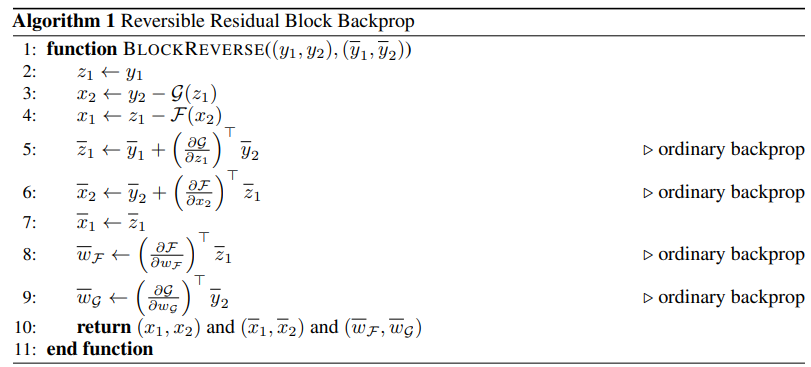

In [509]:
revnet_loss = []
revnet_train_accuracy = []
revnet_test_accuracy = []

def softmax(x):
    ### Your code goes here ###
    assert len(x.shape) == 2

    x_max = np.max(x, axis=1)
    x_max = x_max[:, np.newaxis]
    e_x = np.exp(x - x_max)

    div = np.sum(e_x, axis=1)
    div = div[:, np.newaxis]

    return e_x / div
    ###########################

def cross_entropy(x, y):
    ### Your code goes here ###
    eps = 1e-9
    return -np.mean(np.sum(y * np.log(x + eps), axis=1))
    ###########################

class ReVNet(object):
  def __init__(self, sizes):
    # initialize biases and weights with random normal distr.
    # weights are indexed by target node first
    # sizes should be in form (mnist_size, a, a, a, ...,  a, 10)
    # IMPORTANT: use at least one layer of size a -> a
    ### Your code goes here ###
    self.sizes = sizes

    self.weights = []
    self.weights.append(np.random.randn(sizes[0], sizes[1]))

    for x, y in zip(sizes[1:-1], sizes[2:-1]):
      self.weights.append(np.random.randn(x, y // 2))

    self.weights.append(np.random.randn(sizes[-2], sizes[-1]))

    self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
    ###########################

  def split(self, arr, split_idx):
    split_upper = arr[:split_idx, :]
    split_lower = arr[split_idx:, :]

    return (split_upper, split_lower)

  def feedforward(self, a):
    # Run the network
    ### Your code goes here ###
    a = a.T
    a = sigmoid(np.matmul(self.weights[0].T, a) + self.biases[0])
    x_1, x_2 = self.split(a, a.shape[0] // 2)

    for w, b in zip(self.weights[1:-1], self.biases[1:-1]):
      w_1, w_2 = self.split(w, w.shape[0] // 2)
      b_1, b_2 = self.split(b, b.shape[0] // 2)

      x_1 = x_1 + sigmoid(np.matmul(w_1, x_2) + b_1)
      x_2 = x_2 + sigmoid(np.matmul(w_2, x_1) + b_2)

    a = np.concatenate((x_1, x_2), axis=0)
    a = softmax(np.matmul(self.weights[-1].T, a) + self.biases[-1])

    return a
    ###########################

  def update_mini_batch(self, x_mini_batch, y_mini_batch, eta):
    # Update networks weights and biases by applying a single step
    # of gradient descent using backpropagation to compute the gradient.
    # The gradient is computed for a mini_batch.
    # eta is the learning rate

    ### Your code goes here ###
    nabla_w, nabla_b = self.backpropagation(x_mini_batch.T, y_mini_batch.T)

    self.weights = [w-(eta/len(x_mini_batch))*nw for w, nw in zip(self.weights, nabla_w)]
    self.biases = [b-(eta/len(x_mini_batch))*nb for b, nb in zip(self.biases, nabla_b)]
    ###########################

  def backpropagation(self, x, y):
    ### Your code goes here ###
    f = x
    f = sigmoid(np.matmul(self.weights[0].T, x) + self.biases[0])
    x_1, x_2 = self.split(f, f.shape[0] // 2)

    for w, b in zip(self.weights[1:-1], self.biases[1:-1]):
      w_1, w_2 = self.split(w, w.shape[0] // 2)
      b_1, b_2 = self.split(b, b.shape[0] // 2)

      x_1 = x_1 + sigmoid(np.matmul(w_1, x_2) + b_1)
      x_2 = x_2 + sigmoid(np.matmul(w_2, x_1) + b_2)

    out = np.concatenate((x_1, x_2), axis=0)
    output = softmax(np.matmul(self.weights[-1].T, out) + self.biases[-1])
    output_derivative = self.cost_derivative(output, y)
    dLdf = np.multiply(output_derivative, np.multiply(output, (1-output)))
    dLdg = np.matmul(self.weights[-1], dLdf)
    revnet_loss.append(cross_entropy(output, y))
    y_1 = x_1
    y_2 = x_2
    y_1p, y_2p = self.split(dLdg, dLdg.shape[0] // 2)

    delta_nabla_w = [(np.matmul(dLdf, np.concatenate((x_1, x_2), axis=0).T)).T]
    delta_nabla_b = [np.sum(dLdf, axis=1).reshape(dLdf.shape[0],1)]

    for w, b in reversed(list(zip(self.weights[1:-1], self.biases[1:-1]))):
      w_1, w_2 = self.split(w, w.shape[0] // 2)
      b_1, b_2 = self.split(b, b.shape[0] // 2)

      # 2.
      z_1 = y_1

      # 3. & 4.
      x_2 = y_2 - sigmoid(np.matmul(w_2, z_1) + b_2)
      x_1 = z_1 - sigmoid(np.matmul(w_1, x_2) + b_1)

      # 5.
      y_p = np.multiply(y_2p, sigmoid_prime(y_2 - x_2))
      z_1p = y_1p + np.dot(w_2.T, y_p)

      # 6.
      z_p = np.multiply(z_1p, sigmoid_prime(z_1 - x_1))
      x_2p = y_2p + np.dot(w_1.T, z_p)

      # 7.
      x_1p = z_1p

      # 8. & 9.
      w_1p = np.dot(z_p, x_2.T)
      w_2p = np.dot(y_p, z_1.T)

      grad_w = np.concatenate((w_1p, w_2p), axis=0)
      grad_b = np.concatenate((z_p, y_p), axis=0)

      delta_nabla_w.append(grad_w)
      delta_nabla_b.append(np.sum(grad_b, axis=1).reshape(grad_b.shape[0], 1))

      y_1 = x_1
      y_2 = x_2
      y_1p = x_1p
      y_2p = x_2p

    y_p = np.concatenate((y_1p, y_2p), axis=0)

    layer_1_grad = (y_p * sigmoid_prime(((self.weights[0].T @ x) + self.biases[0])))
    delta_nabla_w.append((layer_1_grad @ x.T).T)
    delta_nabla_b.append(np.sum(layer_1_grad, axis=1).reshape(layer_1_grad.shape[0],1))

    return (reversed(delta_nabla_w), reversed(delta_nabla_b))
    ###########################

  def cost_derivative(self, output_activations, y):
    return (output_activations-y)

  def evaluate(self, x_test_data, y_test_data):
      # Count the number of correct answers for test_data
        pred = np.argmax(self.feedforward(x_test_data),axis=0)
        corr = np.argmax(y_test_data,axis=1).T
        return np.mean(pred==corr)

  @profile
  def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None, logger=None):
      x_train, y_train = training_data
      if test_data:
          x_test, y_test = test_data
      for j in range(epochs):
          for i in range(x_train.shape[0] // mini_batch_size):
              x_mini_batch = x_train[i*mini_batch_size:(i*mini_batch_size + mini_batch_size)]
              y_mini_batch = y_train[i*mini_batch_size:(i*mini_batch_size + mini_batch_size)]
              self.update_mini_batch(x_mini_batch, y_mini_batch, eta)
          if test_data:
              accuracy = self.evaluate(x_test, y_test)
              revnet_test_accuracy.append(accuracy)
              print("Epoch: {0}, Accuracy: {1}".format(j, accuracy))
          else:
              accuracy = self.evaluate(x_train, y_train)
              revnet_train_accuracy.append(accuracy)
              print("Epoch: {0}, Accuracy: {1}".format(j, accuracy))

# Train the network

In [510]:
 ### Your code goes here ###
task = Task.create(project_name='hw1', task_name='revnet_computations')
task.mark_started()
logger = task.get_logger()

task.connect(config)

print("ReVNet train performance:")
network = ReVNet(config['network_size'])
network.SGD((x_train, y_train), epochs=config['n_epochs'], mini_batch_size=config['mini_batch_size'], eta=config['lr'])

for i in range(1, len(revnet_train_accuracy)):
  logger.report_scalar(title='Revnet Accuracy', series='Train', iteration=i, value=revnet_train_accuracy[i])

print("ReVNet test performance:")
network = ReVNet(config['network_size'])
network.SGD((x_train, y_train), epochs=config['n_epochs'], mini_batch_size=config['mini_batch_size'], eta=config['lr'], test_data=(x_test, y_test))

for i in range(1, len(revnet_test_accuracy)):
  logger.report_scalar(title='Revnet Accuracy', series='Test', iteration=i, value=revnet_test_accuracy[i])

for i in range(1, len(revnet_loss)):
  logger.report_scalar(title='Revnet Loss', series='Train & Test', iteration=i, value=revnet_loss[i])

task.mark_completed()
task.close()
###########################

ReVNet train performance:
ERROR: Could not find file <ipython-input-509-9078224360f8>
NOTE: %mprun can only be used on functions defined in physical files, and not in the IPython environment.
Epoch: 0, Accuracy: 0.15335
Epoch: 1, Accuracy: 0.20465
Epoch: 2, Accuracy: 0.23245
Epoch: 3, Accuracy: 0.18613333333333335
Epoch: 4, Accuracy: 0.1396
Epoch: 5, Accuracy: 0.12776666666666667
Epoch: 6, Accuracy: 0.14868333333333333
Epoch: 7, Accuracy: 0.15586666666666665
Epoch: 8, Accuracy: 0.14253333333333335
Epoch: 9, Accuracy: 0.141
Epoch: 10, Accuracy: 0.14035
Epoch: 11, Accuracy: 0.1441
Epoch: 12, Accuracy: 0.15506666666666666
Epoch: 13, Accuracy: 0.14831666666666668
Epoch: 14, Accuracy: 0.1135
Epoch: 15, Accuracy: 0.1138
Epoch: 16, Accuracy: 0.11058333333333334
Epoch: 17, Accuracy: 0.11021666666666667
Epoch: 18, Accuracy: 0.11011666666666667
Epoch: 19, Accuracy: 0.10965
Epoch: 20, Accuracy: 0.10928333333333333
Epoch: 21, Accuracy: 0.109
Epoch: 22, Accuracy: 0.1088
Epoch: 23, Accuracy: 0.10855

<ipython-input-508-03b7a6ea721a>:6: RuntimeWarning:

overflow encountered in exp



Epoch: 19, Accuracy: 0.0223
Epoch: 20, Accuracy: 0.0275
Epoch: 21, Accuracy: 0.0134
Epoch: 22, Accuracy: 0.0294
Epoch: 23, Accuracy: 0.0215
Epoch: 24, Accuracy: 0.0256


In [511]:
# task = Task.create(project_name='hw1', task_name='normal_network_computations')
# task.mark_started()
# logger = task.get_logger()

# task.connect(config)

print("Normal neural network train performance:")
network = Network(config['network_size'])
network.SGD((x_train, y_train), epochs=config['n_epochs'], mini_batch_size=config['mini_batch_size'], eta=config['lr'])

for i in range(1, len(network_train_accuracy)):
  logger.report_scalar(title='Network Accuracy', series='Train', iteration=i, value=network_train_accuracy[i])

print("Normal neural network test performance:")
network = Network(config['network_size'])
network.SGD((x_train, y_train), epochs=config['n_epochs'], mini_batch_size=config['mini_batch_size'], eta=config['lr'], test_data=(x_test, y_test))

for i in range(1, len(network_test_accuracy)):
  logger.report_scalar(title='Network Accuracy', series='Test', iteration=i, value=network_test_accuracy[i])

for i in range(1, len(network_loss)):
  logger.report_scalar(title='Network Loss', series='Train & Train', iteration=i, value=network_loss[i])

task.mark_completed()
task.close()

Normal neural network train performance:
Epoch: 0, Accuracy: 0.37578333333333336
Epoch: 1, Accuracy: 0.4814
Epoch: 2, Accuracy: 0.5756666666666667
Epoch: 3, Accuracy: 0.6460166666666667
Epoch: 4, Accuracy: 0.7168333333333333
Epoch: 5, Accuracy: 0.7553333333333333
Epoch: 6, Accuracy: 0.7799833333333334
Epoch: 7, Accuracy: 0.7965333333333333
Epoch: 8, Accuracy: 0.8098333333333333
Epoch: 9, Accuracy: 0.81945
Epoch: 10, Accuracy: 0.8279833333333333
Epoch: 11, Accuracy: 0.8348166666666667
Epoch: 12, Accuracy: 0.8418166666666667
Epoch: 13, Accuracy: 0.8471
Epoch: 14, Accuracy: 0.8520333333333333
Epoch: 15, Accuracy: 0.85695
Epoch: 16, Accuracy: 0.861
Epoch: 17, Accuracy: 0.8649666666666667
Epoch: 18, Accuracy: 0.86845
Epoch: 19, Accuracy: 0.8717333333333334
Epoch: 20, Accuracy: 0.8746333333333334
Epoch: 21, Accuracy: 0.8771833333333333
Epoch: 22, Accuracy: 0.8794666666666666
Epoch: 23, Accuracy: 0.8813333333333333
Epoch: 24, Accuracy: 0.8835833333333334
Normal neural network test performance

# Training plots for the best training

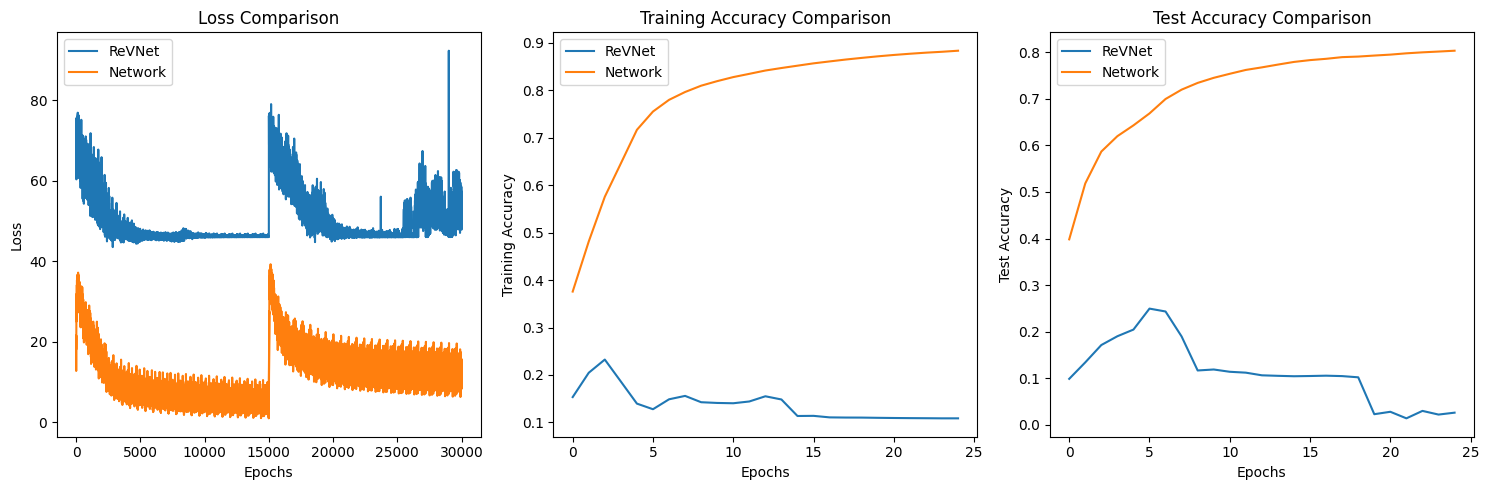

In [512]:
# Plot 1: Loss
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(revnet_loss, label='ReVNet')
plt.plot(network_loss, label='Network')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.legend()

# Plot 2: Training Accuracy
plt.subplot(1, 3, 2)
plt.plot(revnet_train_accuracy, label='ReVNet')
plt.plot(network_train_accuracy, label='Network')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy Comparison')
plt.legend()

# Plot 3: Test Accuracy
plt.subplot(1, 3, 3)
plt.plot(revnet_test_accuracy, label='ReVNet')
plt.plot(network_test_accuracy, label='Network')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Comparison')
plt.legend()

plt.tight_layout()
plt.show()

# Compare memory usage

Hint: you can use memory-profiler library [link](https://pypi.org/project/memory-profiler/)

In [514]:
#  ### Your code goes here ###

# ###########################